Install the [lifelines](https://lifelines.readthedocs.io) library

In [ ]:
!pip install lifelines

In [56]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

import pandas
import gripql
conn = gripql.Connection("https://bmeg.io/api", credential_file="bmeg_credentials.json")
O = conn.graph("bmeg_rc2")

Look at the TCGA-BRCA cohort, and find all of the cases where there is a recorded `days_to_death`

In [40]:
q = O.query().V("Project:TCGA-BRCA").out("cases")

data = {}
for i in q:
    if i.data.gdc_attributes.demographic is not None and i.data.gdc_attributes.demographic.vital_status == "Dead":
        if 'days_to_death' in i.data.gdc_attributes.demographic:
            data[ i.gid ] = i.data.gdc_attributes.demographic.days_to_death
survival = pandas.Series(data)

[INFO]	2019-07-26 21:19:47,291	1,098 results received in 0 seconds


Gene ensembl gene id for `TP53`

In [37]:
gene = list(O.query().V().hasLabel("Gene").has(gripql.eq("symbol", "TP53")))[0].data.gene_id
print(gene)

[INFO]	2019-07-26 21:18:49,921	1 results received in 0 seconds


ENSG00000141510


Starting from the cases with attached survival information, find all of the cases that have a mutation in the gene on interest

In [41]:
q = O.query().V(list(survival.keys())).as_("case").out("samples").out("aliquots").out("somatic_callsets").outE("alleles")
q = q.has(gripql.eq("ensembl_gene", gene))
q = q.select("case").distinct("$._gid").render("$._gid")
mut_cases = list(q)

[INFO]	2019-07-26 21:20:14,268	52 results received in 0 seconds


Plot a Kaplan Meirer curve to demonstrate the different in survival of the somatic mutation group and those with no somatic mutation.

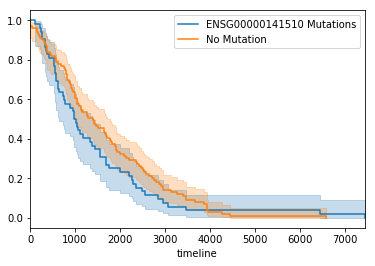

In [65]:
kmf = KaplanMeierFitter()

ax = plt.subplot(111)
kmf.fit(survival[mut_cases], label="%s Mutations" % (gene))
ax = kmf.plot(ax=ax)
kmf.fit(survival[ survival.index.difference(mut_cases) ], label="No Mutation")
kmf.plot(ax=ax)